[Базовая статья](https://boascents2.medium.com/step-by-step-multi-label-image-classification-with-pytorch-gpu-e34d0aa6d578])

In [1]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
from tqdm.notebook import tqdm
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.device_count()

1

In [4]:
torch.cuda.current_device()

0

In [5]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1050 Ti'

In [6]:
torch.cuda.mem_get_info()

(3522586215, 4294705152)

In [7]:
torch.cuda.empty_cache()

In [8]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():  
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device       

    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [9]:
data_train_dir = 'D:/EDUCATION/DATA/OTUS_ML_P/train_images'
data_test_dir = 'D:/EDUCATION/DATA/OTUS_ML_P/test_images'

In [10]:
print(os.listdir(data_train_dir))
print(len(os.listdir(data_train_dir)))
print(os.listdir(data_test_dir))
print(len(os.listdir(data_test_dir)))

['0011165.jpg', '002be4f.jpg', '0031ae9.jpg', '0035239.jpg', '003994e.jpg', '00498ec.jpg', '006bf7c.jpg', '006c5a6.jpg', '008233e.jpg', '008a5ff.jpg', '0091591.jpg', '0095357.jpg', '009e2f3.jpg', '00a0954.jpg', '00b81e1.jpg', '00bea06.jpg', '00cedfa.jpg', '00d4443.jpg', '00dec6a.jpg', '0100a84.jpg', '0104b5b.jpg', '0107838.jpg', '0118bff.jpg', '011ba04.jpg', '01242d7.jpg', '014310a.jpg', '0146ef3.jpg', '0153a8b.jpg', '015aa06.jpg', '015b764.jpg', '016c135.jpg', '017ded1.jpg', '0187cd7.jpg', '01a7865.jpg', '01c6ec3.jpg', '01eecc1.jpg', '0208ccf.jpg', '021bb26.jpg', '0225687.jpg', '022a275.jpg', '022d78c.jpg', '022fd47.jpg', '023accd.jpg', '025ad96.jpg', '02601cd.jpg', '0269e9a.jpg', '027000d.jpg', '0277e9a.jpg', '028fd83.jpg', '028fe8a.jpg', '029b861.jpg', '02b6a5d.jpg', '02c3e33.jpg', '030ac75.jpg', '031bfc5.jpg', '0326622.jpg', '0330f49.jpg', '034a383.jpg', '034ef1c.jpg', '0358d2e.jpg', '0362b0a.jpg', '0365c50.jpg', '038407e.jpg', '03a5e35.jpg', '03b1dc4.jpg', '03c3906.jpg', '03eb81a.

In [11]:
classes = ['Fish', 'Flower', 'Gravel', 'Sugar']

In [12]:
def encode_target(labels, classes=classes):
    target = torch.zeros(len(classes))
    for label in labels:
        index = classes.index(label)
        target[index] = 1
    return target

def decode_target(target, classes=classes, threshold=0.5):
    result = []
    for index, value in enumerate(target):
        if value > threshold:
            result.append(classes[index])
    return ' '.join(result)

In [13]:
def get_file_names(path):
    result = []
    for _, _, file_names in os.walk(path):  
        for file_name in file_names:
                result.append(file_name)
    return result

def get_labels(file_path):
    labels = {}
    
    data = pd.read_csv(file_path)
    data['File_Name'] = data['Image_Label'].apply(lambda x: x.split('_')[0])
    data['Label'] = data['Image_Label'].apply(lambda x: x.split('_')[1])

    data = data[data['EncodedPixels'].notna()]

    for _, row in data.iterrows():
        if row['File_Name'] not in labels:
            labels[row['File_Name']] = []
        labels[row['File_Name']].append(row['Label'])

    return labels

In [14]:
class ImagesDataset(Dataset):
    def __init__(self, train_images_path='D:/EDUCATION/DATA/OTUS_ML_P/TRAIN_IMAGES', train_labels_file_path='D:/EDUCATION/DATA/OTUS_ML_P/TRAIN.CSV'):
        self.train_images_path = train_images_path
        self.train_labels_file_path = train_labels_file_path

        self.images = get_file_names(train_images_path)
        self.labels = get_labels(train_labels_file_path)
      

    def __len__(self):
        return len(self.images)       

    def __getitem__(self, index):
        transform = T.Compose([T.ToTensor()])

        image_file_name = self.images[index]
        image = transform(Image.open(os.path.join(self.train_images_path, image_file_name)))
        
        return image, encode_target(self.labels[image_file_name])       

In [15]:
data = ImagesDataset()
data[0]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.9098, 0.8902, 0.8588],
          [0.0000, 0.0000, 0.0000,  ..., 0.9176, 0.8784, 0.8314],
          [0.0000, 0.0000, 0.0000,  ..., 0.8314, 0.7569, 0.6902],
          ...,
          [0.0588, 0.0588, 0.0588,  ..., 0.3922, 0.4863, 0.5843],
          [0.0549, 0.0549, 0.0588,  ..., 0.4196, 0.5216, 0.5961],
          [0.0549, 0.0549, 0.0549,  ..., 0.4471, 0.5569, 0.5922]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.9098, 0.8902, 0.8588],
          [0.0000, 0.0000, 0.0000,  ..., 0.9176, 0.8784, 0.8314],
          [0.0000, 0.0000, 0.0000,  ..., 0.8314, 0.7569, 0.6902],
          ...,
          [0.1059, 0.1059, 0.1059,  ..., 0.3961, 0.4902, 0.5882],
          [0.1020, 0.1020, 0.1059,  ..., 0.4235, 0.5255, 0.6000],
          [0.1020, 0.1020, 0.1020,  ..., 0.4510, 0.5608, 0.5961]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.9020, 0.8824, 0.8510],
          [0.0000, 0.0000, 0.0000,  ..., 0.9098, 0.8706, 0.8235],
          [0.0000, 0.0000, 0.0000,  ...,

In [16]:
train_size = len(data) - int(0.15 * len(data))
val_size = len(data) - train_size
train_size, val_size

(4715, 831)

In [17]:
train_ds, val_ds = random_split(data, [train_size, val_size])
len(train_ds), len(val_ds)

(4715, 831)

In [18]:
batch_size = 1 #2
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size * 2)

In [19]:
for xb, yb in train_loader:
  print(xb.shape)
  print(yb.shape)
  break

torch.Size([1, 3, 1400, 2100])
torch.Size([1, 4])


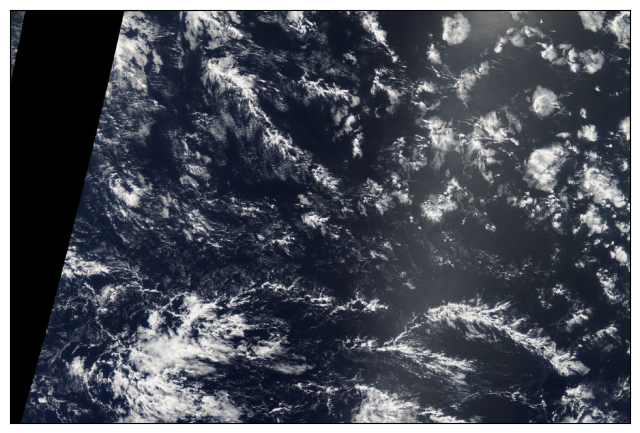

In [20]:
def show_batch(dl, nmax=16):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:nmax], nrow=4).permute(1, 2, 0))
        break

show_batch(train_loader)

In [21]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)


class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                            # Generate predictions
        loss = F.binary_cross_entropy(out, targets)   # Calculate loss
        return loss    

    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)                # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_score': score.detach() }      


    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine losses and get the mean value
        batch_scores = [x['val_score'] for x in outputs]    
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies and get the mean value
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}    

    def epoch_end(self, epoch, result):                     # display the losses
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))


In [22]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)

In [23]:
for xb, yb in train_dl:
  print(xb.shape)
  print(yb.shape)
  break

torch.Size([1, 3, 1400, 2100])
torch.Size([1, 4])


In [24]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    
    for epoch in range(epochs):
        
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader)) #schedule the learning rate with OneCycleLR

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader: #tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Попробовал создать сеть с нуля (ResNet15). Обучение очень затратно по времени: после трёх суток обучения прекатил обучение. Воспользовался предобученной нейронной сетью resnext50_32x4d.

In [25]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]

    if pool: layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


class ResNet15(MultilabelImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()     
                                                                                                #  3 x 1400 x 2100
        self.conv1 = conv_block(in_channels, 32)                                                # 32 x 1400 x 2100
        self.res1 = nn.Sequential(conv_block(32, 32), conv_block(32, 32))                       # 32 x 1400 x 2100


        self.conv2 = conv_block(32, 64, pool=True)                                              # 64 x 350 x 525
        self.res2 = nn.Sequential(conv_block(64, 64), conv_block(64, 64), conv_block(64, 64))   # 64 x 350 x 525


        self.conv3 = conv_block(64, 256, pool=True)                                             # 256 x 87 x 131
        self.res3 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))                   # 256 x 87 x 131


        self.conv4 = conv_block(256, 512, pool=True)                                            # 512 x 21 x 32
        self.res4 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))                   # 512 x 21 x 32


        self.classifier = nn.Sequential(nn.MaxPool2d(2),                                        # 512 x 10 x 16
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(81920 * 1 * 1, 256),
                                        nn.ReLU(),
                                        nn.Linear(256, num_classes))                            # output 4    

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.res1(out) + out
        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.conv3(out)
        out = self.res3(out) + out
        out = self.conv4(out)
        out = self.res4(out) + out
        out = self.classifier(out)
        out = F.sigmoid(out)
        return out

In [26]:
class Resnext50(MultilabelImageClassificationBase):
    def __init__(self, n_classes):
        super().__init__()
        resnet = models.resnext50_32x4d(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False
            
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

In [27]:
model = to_device(Resnext50(len(classes)), device) #to_device(ResNet15(3, len(classes)), device)
model

Resnext50(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): 

In [28]:
for images, labels in train_dl:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

torch.Size([1, 3, 1400, 2100])
outputs.shape :  torch.Size([1, 4])
Sample outputs :
 tensor([[0.5434, 0.5957, 0.4598, 0.5199]], device='cuda:0')


In [29]:
torch.cuda.empty_cache()

In [30]:
torch.cuda.mem_get_info()

(3310773863, 4294705152)

In [31]:
#history = [evaluate(model, val_dl)]
#history

In [32]:
epochs = 5
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [33]:
for name, param in model.named_parameters():
    print(name, param.shape, param.requires_grad)

base_model.conv1.weight torch.Size([64, 3, 7, 7]) False
base_model.bn1.weight torch.Size([64]) False
base_model.bn1.bias torch.Size([64]) False
base_model.layer1.0.conv1.weight torch.Size([128, 64, 1, 1]) False
base_model.layer1.0.bn1.weight torch.Size([128]) False
base_model.layer1.0.bn1.bias torch.Size([128]) False
base_model.layer1.0.conv2.weight torch.Size([128, 4, 3, 3]) False
base_model.layer1.0.bn2.weight torch.Size([128]) False
base_model.layer1.0.bn2.bias torch.Size([128]) False
base_model.layer1.0.conv3.weight torch.Size([256, 128, 1, 1]) False
base_model.layer1.0.bn3.weight torch.Size([256]) False
base_model.layer1.0.bn3.bias torch.Size([256]) False
base_model.layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1]) False
base_model.layer1.0.downsample.1.weight torch.Size([256]) False
base_model.layer1.0.downsample.1.bias torch.Size([256]) False
base_model.layer1.1.conv1.weight torch.Size([128, 256, 1, 1]) False
base_model.layer1.1.bn1.weight torch.Size([128]) False
base_mod

In [36]:
result = []
result += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [0], last_lr: 0.0008, train_loss: 0.7105, val_loss: 0.7004, val_score: 0.3994
Epoch [1], last_lr: 0.0010, train_loss: 0.8351, val_loss: 0.8218, val_score: 0.6490
Epoch [2], last_lr: 0.0006, train_loss: 0.9026, val_loss: 0.7672, val_score: 0.5750
Epoch [3], last_lr: 0.0002, train_loss: 0.9062, val_loss: 0.7728, val_score: 0.6075
Epoch [4], last_lr: 0.0000, train_loss: 0.8820, val_loss: 0.8436, val_score: 0.4672


In [37]:
result

[{'val_loss': 0.7004451155662537,
  'val_score': 0.3994218409061432,
  'train_loss': 0.7104743123054504,
  'lrs': [3.9999999999999996e-05,
   4.000004736830979e-05,
   4.0000189473229854e-05,
   4.000042631473221e-05,
   4.000075789277002e-05,
   4.00011842072777e-05,
   4.000170525817143e-05,
   4.00023210453481e-05,
   4.0003031568686294e-05,
   4.000383682804592e-05,
   4.0004736823267824e-05,
   4.000573155417441e-05,
   4.000682102056933e-05,
   4.000800522223759e-05,
   4.0009284158945644e-05,
   4.001065783044088e-05,
   4.001212623645214e-05,
   4.0013689376689724e-05,
   4.0015347250845065e-05,
   4.001709985859106e-05,
   4.0018947199581636e-05,
   4.002088927345228e-05,
   4.002292607981962e-05,
   4.002505761828163e-05,
   4.002728388841775e-05,
   4.002960488978845e-05,
   4.0032020621935975e-05,
   4.003453108438295e-05,
   4.003713627663444e-05,
   4.0039836198175875e-05,
   4.0042630848474594e-05,
   4.0045520226978954e-05,
   4.004850433311877e-05,
   4.005158316630489